In [1]:
#eda import
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import sklearn

In [2]:
df = pd.read_csv('dataset/total.csv')

(array([    0., 10000., 20000., 30000., 40000., 50000.]),
 [Text(0.0, 0, '0'),
  Text(10000.0, 0, '10000'),
  Text(20000.0, 0, '20000'),
  Text(30000.0, 0, '30000'),
  Text(40000.0, 0, '40000'),
  Text(50000.0, 0, '50000')])

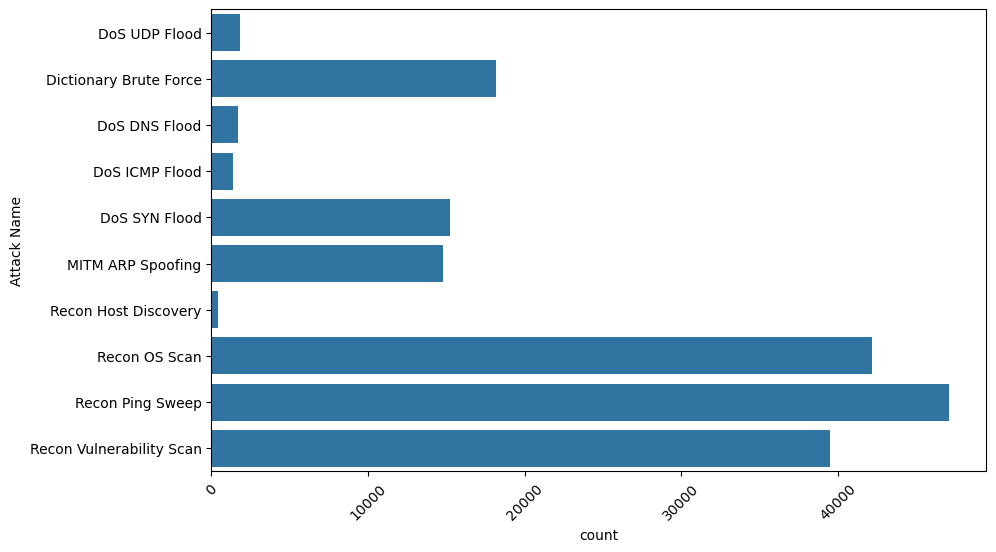

In [3]:
# attack_name 별 개수 시각화
plt.figure(figsize=(10, 6))
sns.countplot(df['Attack Name'])
plt.xticks(rotation=45)


In [4]:
#nunique값이 1인 값이 있는지 확인
df.columns[df.nunique() == 1]

Index(['Protocol', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg', 'Label'],
      dtype='object')

In [5]:
#확인 후 drop
df.drop(['Protocol', 'Bwd PSH Flags', 'Bwd URG Flags', 'Fwd Bytes/Bulk Avg',
       'Fwd Packet/Bulk Avg', 'Fwd Bulk Rate Avg'], axis=1, inplace=True)

In [6]:
#nunique값이 5이하인 값이 있는지 확인
df.columns[df.nunique() <= 5]

Index(['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'RST Flag Count',
       'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count',
       'Fwd Seg Size Min', 'Label'],
      dtype='object')

In [7]:
#nunique값이 5이하인 unique값 확인.
for col in df.columns[df.nunique() <= 5]:
    print(col, df[col].unique())

Fwd PSH Flags [0 1]
Fwd URG Flags [0 1]
FIN Flag Count [1 0 2 3]
RST Flag Count [0 1 2]
URG Flag Count [0 2 1]
CWR Flag Count [0 1]
ECE Flag Count [0 2 1]
Fwd Seg Size Min [20 32 40 44 24]
Label [1]


In [8]:
# nunique값이 5이하인 값들은(flag만) 모두 label encoding으로 처리. 상관관계 분석을 위함이며, 이후 one-hot encoding으로 처리할 예정.
from sklearn.preprocessing import LabelEncoder
for col in ['Fwd PSH Flags', 'Fwd URG Flags', 'FIN Flag Count', 'RST Flag Count',
       'URG Flag Count', 'CWR Flag Count', 'ECE Flag Count']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])


In [9]:
# 그 외 필요없는 column drop(ip, port, timestamp)
df.drop(['Flow ID', 'Src IP', 'Src Port', 'Dst IP', 'Dst Port', 'Timestamp'], axis=1, inplace=True)

In [10]:
#한번에 제거가 안되니 4번 반복
for i in range(10):
    # 상관관계 분석
    # 숫자형 데이터만 추출
    numeric_data = df.select_dtypes(include=[np.number])
    corr = numeric_data.corr()
    # 상관관계 수치가 0.8 이상인 column 찾은 후 drop
    corr = corr.abs() # 상관계수 절대값으로 변경
    high_corr = corr[corr > 0.8] # 상관계수가 0.8 이상인 값만 추출
    high_corr = high_corr[high_corr < 1] # 대각선 값 제외
    high_corr = high_corr.dropna(axis=1, how='all') # 모든 값이 NaN인 column 제외
    high_corr = high_corr.dropna(axis=0, how='all') # 모든 값이 NaN인 row 제외
    high_corr = high_corr.unstack().sort_values(ascending=False).drop_duplicates()
    # high_corr에서 컬럼 쌍 추출
    columns_to_drop = set()
    already_processed = set()
    for index, value in high_corr.items():
        col1, col2 = index

        # col1 또는 col2 중 하나를 제거
        if col1 not in already_processed and col2 not in already_processed:
            columns_to_drop.add(col2)  # col2를 제거 리스트에 추가
            already_processed.add(col1)
            already_processed.add(col2)

    # DataFrame에서 선택된 컬럼 제거
    df = df.drop(columns=list(columns_to_drop))

    # 결과 출력
    print(f"드롭된 컬럼: {columns_to_drop}")
    print(f"드롭 후 데이터프레임 형태: {df.shape}")

드롭된 컬럼: {'Idle Mean', 'Total Length of Fwd Packet', 'Bwd Packet/Bulk Avg', 'Bwd Header Length', 'Fwd IAT Total', 'Packet Length Max', 'Fwd IAT Mean', 'Active Mean', 'Bwd IAT Mean', 'ACK Flag Count', 'Bwd Bytes/Bulk Avg', 'Fwd Packet Length Max', 'CWR Flag Count', 'Fwd Packets/s', 'Idle Max', 'Fwd URG Flags', 'Packet Length Mean', 'Bwd Packet Length Max', 'Fwd IAT Max', 'Subflow Bwd Bytes', 'Bwd Packet Length Mean'}
드롭 후 데이터프레임 형태: (182326, 52)
드롭된 컬럼: {'Flow IAT Max', 'Total Bwd packets', 'Flow IAT Std', 'Fwd Packet Length Std', 'Bwd Segment Size Avg', 'Subflow Bwd Packets', 'Average Packet Size', 'Fwd Header Length', 'Bwd IAT Total', 'Flow IAT Mean'}
드롭 후 데이터프레임 형태: (182326, 42)
드롭된 컬럼: {'Flow Duration', 'Packet Length Variance', 'Idle Min'}
드롭 후 데이터프레임 형태: (182326, 39)
드롭된 컬럼: {'Bwd IAT Min'}
드롭 후 데이터프레임 형태: (182326, 38)
드롭된 컬럼: set()
드롭 후 데이터프레임 형태: (182326, 38)
드롭된 컬럼: set()
드롭 후 데이터프레임 형태: (182326, 38)
드롭된 컬럼: set()
드롭 후 데이터프레임 형태: (182326, 38)
드롭된 컬럼: set()
드롭 후 데이터프레임 형태: (18232

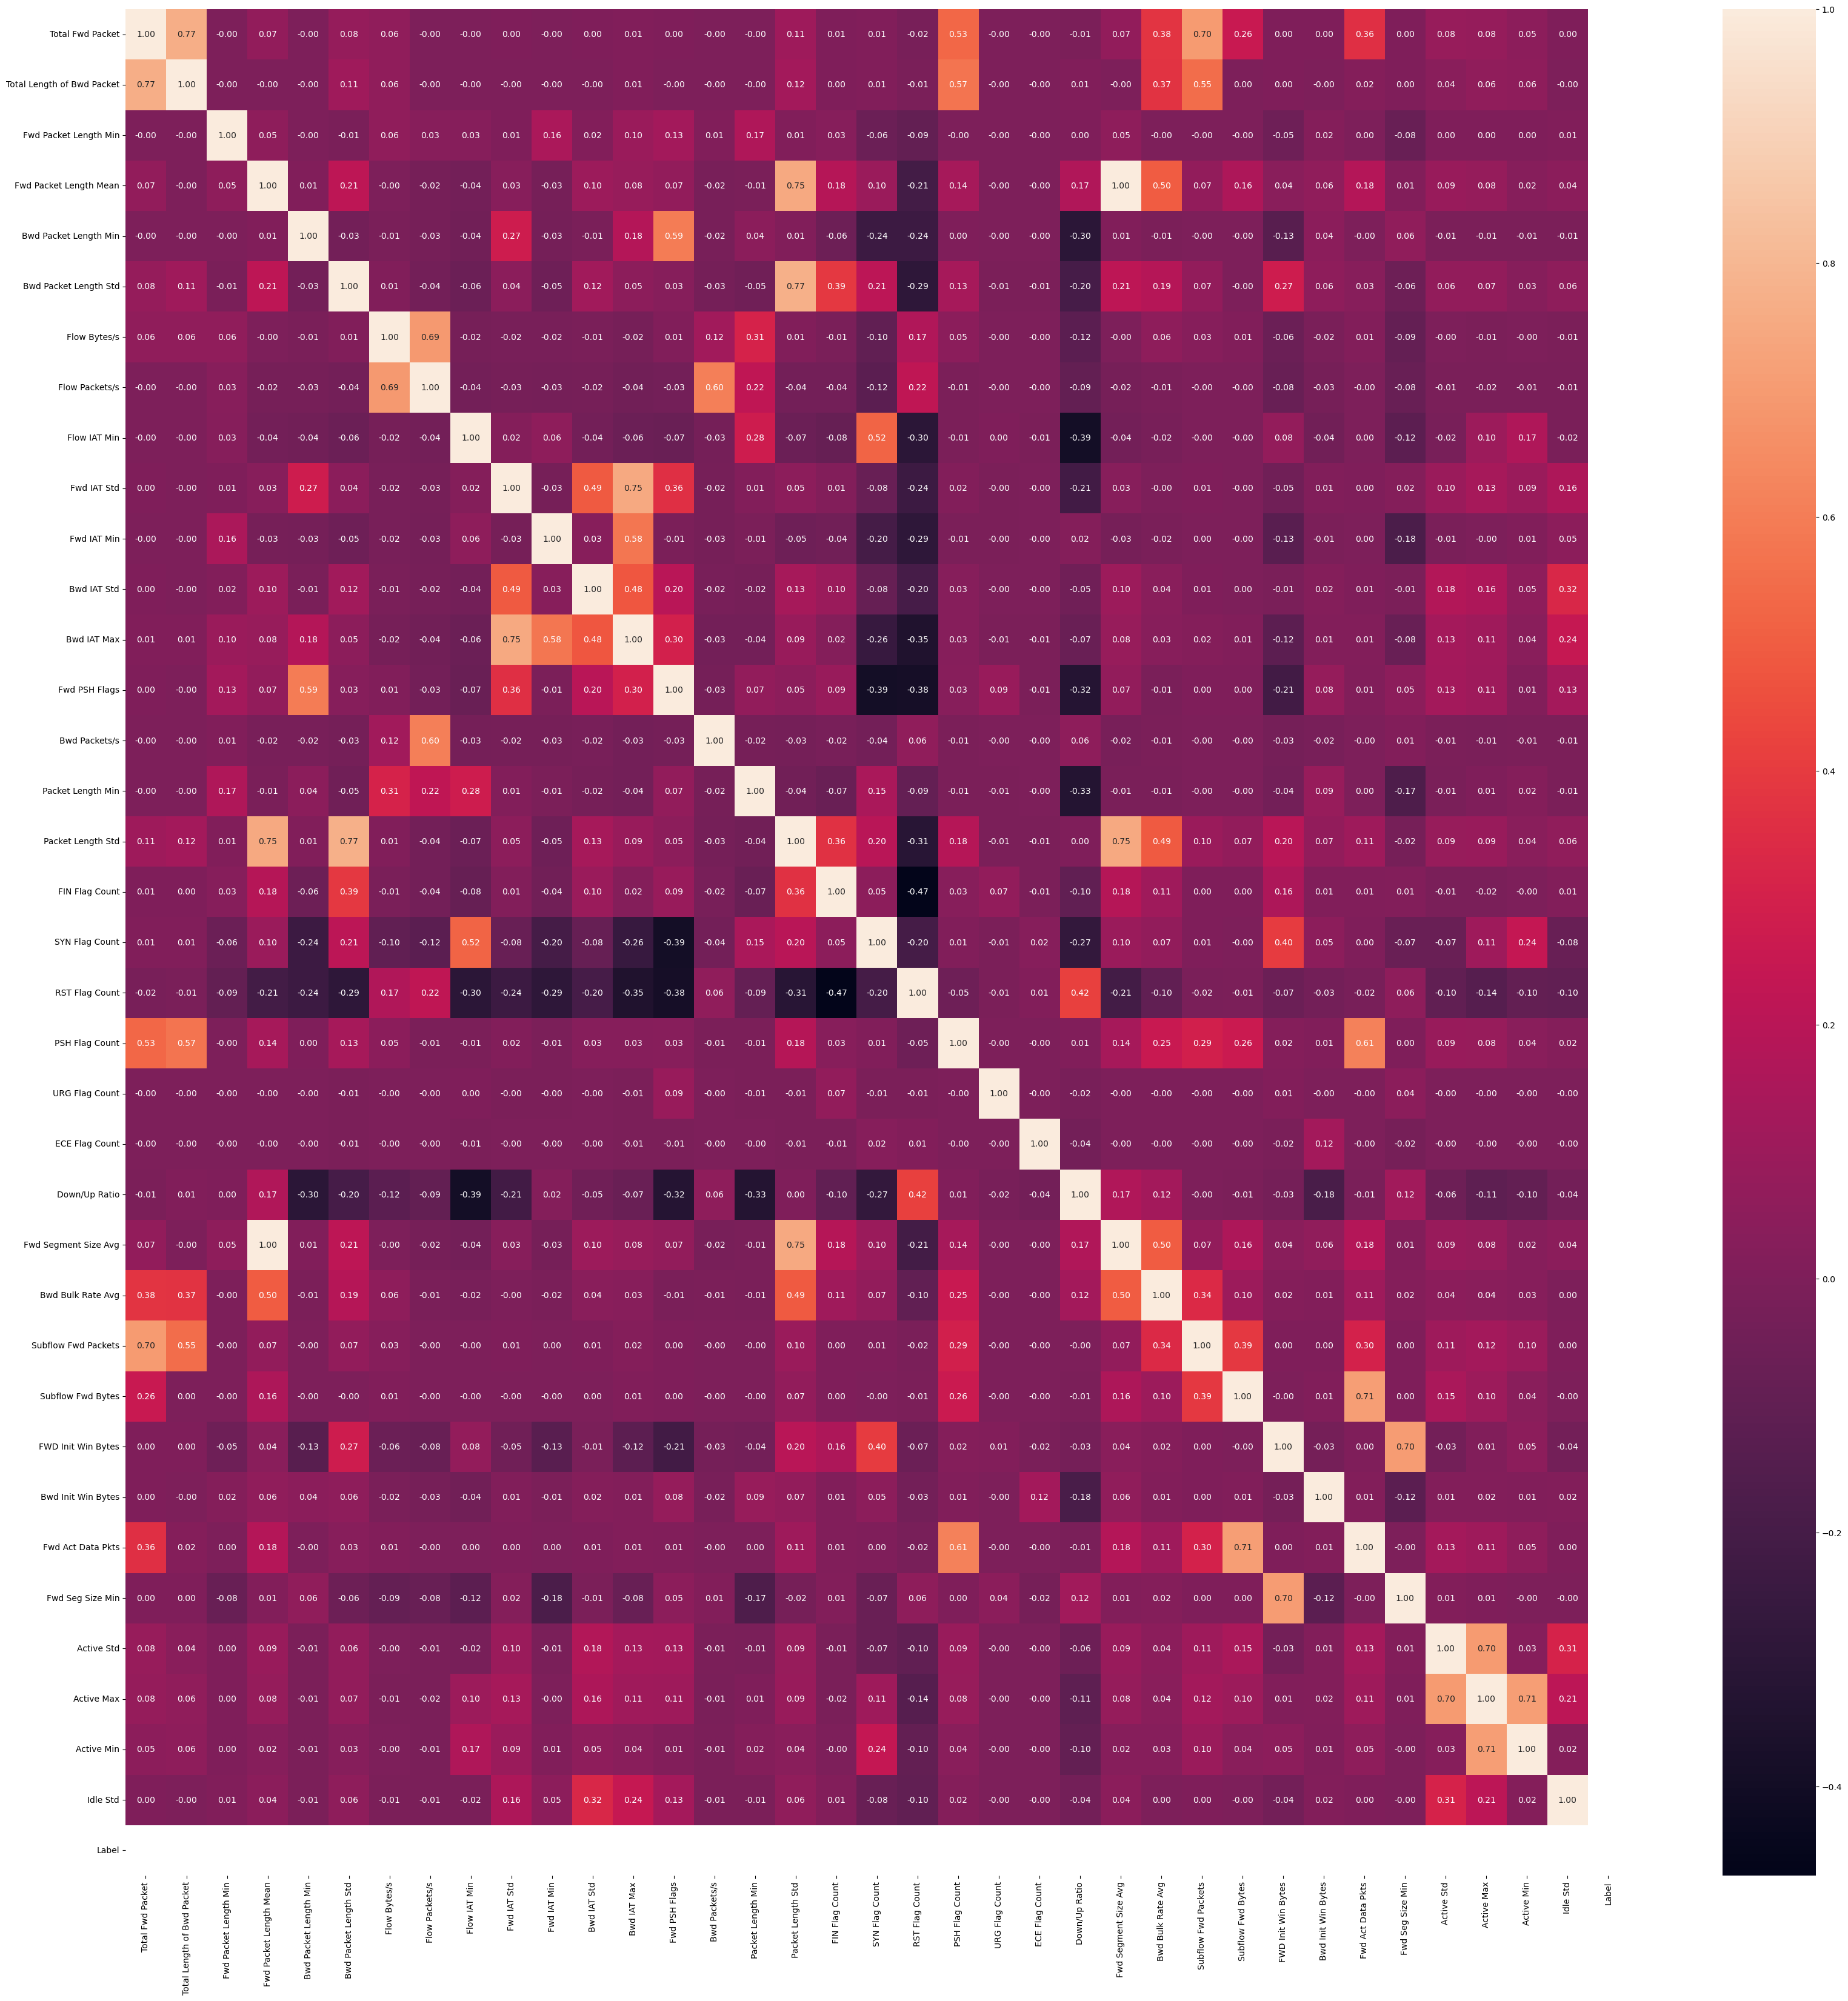

In [11]:
#correlation 재확인
numeric_data = df.select_dtypes(include=[np.number])
corr = numeric_data.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(corr, annot=True, fmt='.2f')
plt.show()

In [12]:
# 상관관계 분석 이후 one-hot encoding으로 다시 되돌려주기
onehot = ['Fwd PSH Flags', 'FIN Flag Count', 'RST Flag Count', 'URG Flag Count', 'ECE Flag Count']
df = pd.get_dummies(df, columns=onehot)

In [ ]:
# y값으로 attack name을 쓸 거라서 Label은 drop
df.drop(['Label'], axis=1, inplace=True)